In [1]:
import pandas as pd
old_data = pd.read_csv("cleaned_data.csv")

In [2]:
old_data

,Unnamed: 0,text,label
0,0,витино кингисепп дорога идеальный,Дорога с идеальным или близким к идеальному по...
1,1,качество покрытие отличный постоянно ремонт ул...,Дорога с идеальным или близким к идеальному по...
2,2,трасса зеркало видимо давно обновлять инф,Дорога с идеальным или близким к идеальному по...
3,3,чистить асфальт ровный выбоина,Дорога с идеальным или близким к идеальному по...
4,4,отличный дорога,Дорога с идеальным или близким к идеальному по...
...,...,...,...
11848,9956,м-38 омск казахстан дорога самый хороший асфал...,Дорога со значительными разрушениями дорожного...
11849,9957,хребтовый усть-кут плохой дорога время путь 5 30,"Дорожное покрытие полностью разрушено, постоян..."
11850,9958,4,Дорога с относительно ровным дорожным полотном
11851,9959,трасса тотьма -никольск слово негатив результа...,"Дорожное покрытие полностью разрушено, постоян..."


In [3]:
labels = old_data['label'].unique()[:-1]

In [4]:
data = old_data.loc[old_data.label.isin(labels)]
data = data[data['text'].apply(type) == str]

In [5]:
# Заменяем названия классов на 0 или 1
data['label'].replace(labels[0], 1, inplace=True)
data['label'].replace(labels[1:], 0, inplace=True)

In [6]:
X_data = data['text'].tolist()
y_data = data['label'].tolist()

In [7]:
old_data[old_data['text'].apply(type) == str]

,Unnamed: 0,text,label
0,0,витино кингисепп дорога идеальный,Дорога с идеальным или близким к идеальному по...
1,1,качество покрытие отличный постоянно ремонт ул...,Дорога с идеальным или близким к идеальному по...
2,2,трасса зеркало видимо давно обновлять инф,Дорога с идеальным или близким к идеальному по...
3,3,чистить асфальт ровный выбоина,Дорога с идеальным или близким к идеальному по...
4,4,отличный дорога,Дорога с идеальным или близким к идеальному по...
...,...,...,...
11848,9956,м-38 омск казахстан дорога самый хороший асфал...,Дорога со значительными разрушениями дорожного...
11849,9957,хребтовый усть-кут плохой дорога время путь 5 30,"Дорожное покрытие полностью разрушено, постоян..."
11850,9958,4,Дорога с относительно ровным дорожным полотном
11851,9959,трасса тотьма -никольск слово негатив результа...,"Дорожное покрытие полностью разрушено, постоян..."


0.9923495067445138

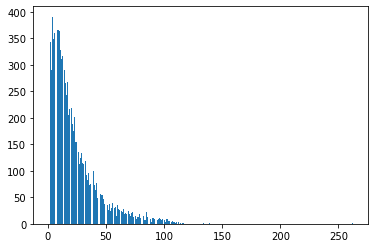

In [8]:
from collections import Counter
from matplotlib import pyplot as plt
lens = [len(x.split()) for x in X_data]
len_counter = Counter(lens)
plt.bar(len_counter.keys(), len_counter.values())
len([l for l in lens if l < 100]) / len(lens)

In [9]:
# Разделение всей выборки на обучающую (80%), валидационную (10%) и тестовую (10%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

In [10]:
# использование токенайзера DeepPavlov
import torch
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased", 
                                          do_lower_case=True)

In [11]:
X_train = tokenizer.batch_encode_plus(X_train, add_special_tokens=True, 
                                      padding='max_length', truncation=True, max_length=100, 
                                      return_tensors='pt', return_attention_mask=True)

X_val = tokenizer.batch_encode_plus(X_val, add_special_tokens=True, 
                                    padding='max_length', truncation=True, max_length=100, 
                                    return_tensors='pt', return_attention_mask=True)

X_test = tokenizer.batch_encode_plus(X_test, add_special_tokens=True, 
                                     padding='max_length', truncation=True, max_length=100, 
                                     return_tensors='pt', return_attention_mask=True)

y_train, y_val, y_test = (torch.LongTensor(y) for y in [y_train, y_val, y_test])

In [12]:
# деление множества на батчи
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_data = TensorDataset(X_train['input_ids'], X_train['attention_mask'], y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(X_val['input_ids'], X_val['attention_mask'], y_val)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(X_test['input_ids'], X_test['attention_mask'])
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [13]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", 
                                                      num_labels = 2, 
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [15]:
from transformers import get_linear_schedule_with_warmup

n_epochs = 8
n_steps = len(train_dataloader) * n_epochs
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = n_steps)

In [16]:
import random
from datetime import timedelta
import time
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device("cuda")
seed = 42

random.seed = (seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model.cuda()

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    print("Training {} epoch".format(epoch + 1))
    start = time.time()
    mean_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        
        torch.cuda.empty_cache()
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        
        torch.cuda.empty_cache()
        outputs = model(b_input_ids, attention_mask=b_attention_masks, labels = b_labels)
        loss = outputs[0]
        
        mean_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
    mean_loss = mean_loss / len(train_dataloader)
    
    train_losses.append(mean_loss)
    print("Mean loss: " , mean_loss)
    print("Training epoch took:" , timedelta(seconds=int(time.time() - start)))
    
    print()
    print("Validation:")
    model.eval()
    
    start = time.time()
    predictions = torch.Tensor().to(dtype=torch.int8)
    val_loss = 0
    
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_masks, labels=b_labels,
                            output_hidden_states=False, output_attentions=False, return_dict=True)
            val_loss += outputs[0].item()
        
        predictions = torch.cat((predictions, outputs.logits.cpu().argmax(axis=1)))
        torch.cuda.empty_cache()
        
    val_losses.append(val_loss / len(val_dataloader))
    print("Precision {:4.2f}, recall {:4.2f}, F1 {:4.2f}".format(*[a(y_val, predictions)
                                                                   for a in (precision_score, recall_score, f1_score)]))
    print("Validation took: {:}".format(timedelta(seconds = int(time.time() - start))))
    print()

Training 1 epoch
Mean loss:  0.37251975951000477
Training epoch took: 0:02:55

Validation:
Precision 0.70, recall 0.71, F1 0.71
Validation took: 0:00:05

Training 2 epoch
Mean loss:  0.2635732809685066
Training epoch took: 0:03:08

Validation:
Precision 0.74, recall 0.76, F1 0.75
Validation took: 0:00:05

Training 3 epoch
Mean loss:  0.18805821026043903
Training epoch took: 0:03:07

Validation:
Precision 0.80, recall 0.70, F1 0.75
Validation took: 0:00:05

Training 4 epoch
Mean loss:  0.1300658223203288
Training epoch took: 0:03:11

Validation:
Precision 0.74, recall 0.79, F1 0.76
Validation took: 0:00:05

Training 5 epoch
Mean loss:  0.1003251843404126
Training epoch took: 0:03:01

Validation:
Precision 0.85, recall 0.71, F1 0.77
Validation took: 0:00:05

Training 6 epoch
Mean loss:  0.06059102387770905
Training epoch took: 0:02:49

Validation:
Precision 0.83, recall 0.71, F1 0.77
Validation took: 0:00:05

Training 7 epoch
Mean loss:  0.0400829852545321
Training epoch took: 0:02:41

V

In [17]:
print("Testing:")
model.eval()

t0 = time.time()
predictions = torch.Tensor().to(dtype=torch.int8)

for batch in test_dataloader:

    b_input_ids = batch[0].to(device)
    b_attention_masks = batch[1].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_masks, output_hidden_states=False, output_attentions=False, return_dict=True)

    predictions = torch.cat((predictions, outputs.logits.cpu().argmax(axis=1)))

print(classification_report(y_test, predictions))

Testing:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       809
           1       0.84      0.65      0.74       185

    accuracy                           0.91       994
   macro avg       0.88      0.81      0.84       994
weighted avg       0.91      0.91      0.91       994



In [18]:
torch.save(model, "model_bert_74_8.pt")